In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

In [3]:

# get the image and their corresponding labels
dataset_path = Path("/content/WM28kL_224x224")
images = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: x.parents[0].stem, images))
print(len(labels), "Images detected in dataset")
# print(images)

28467 Images detected in dataset


In [4]:
# getting the dataset in a Dataframe for convenience

images = pd.Series(images, name="Images").astype(str)
labels = pd.Series(labels, name="Labels").astype(str)

data = pd.concat([images, labels], axis = 1)
data = data.sample(frac = 1, random_state = 42).reset_index(drop = True)
data.head()

,Images,Labels
0,/content/WM28kL_224x224/Edge-Loc/17663.jpg,Edge-Loc
1,/content/WM28kL_224x224/Scratch/4543.jpg,Scratch
2,/content/WM28kL_224x224/Edge-Ring/10644.jpg,Edge-Ring
3,/content/WM28kL_224x224/Edge-Ring/11479.jpg,Edge-Ring
4,/content/WM28kL_224x224/Center/9130.jpg,Center


/tmp/ipython-input-5-3735255953.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imageio.imread(data.Images[i]))


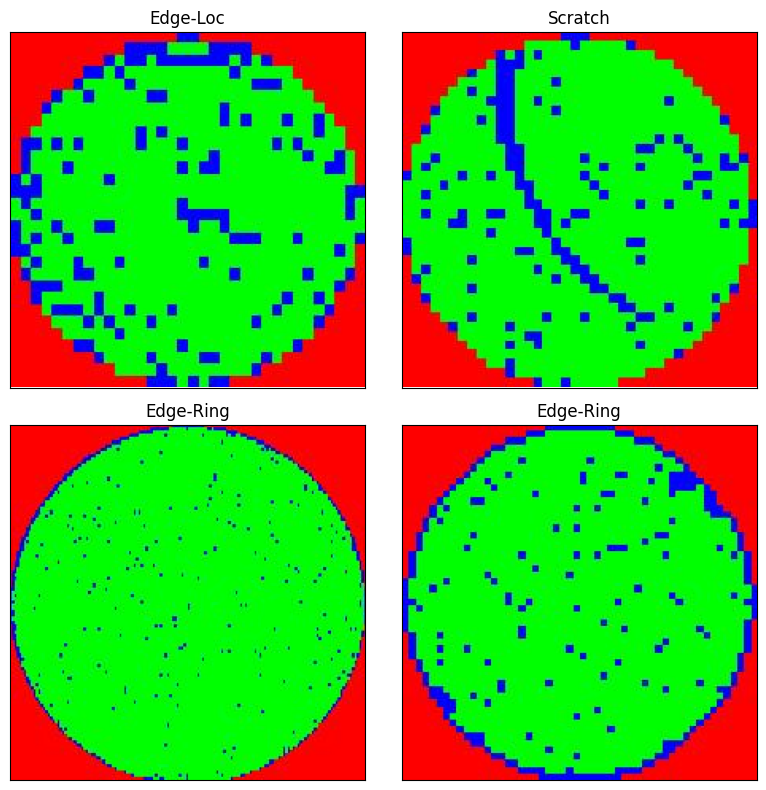

In [5]:

# small sample of the data
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(imageio.imread(data.Images[i]))
  ax.set_title(data.Labels[i])
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()

# Data Augmentations

In [6]:
# Using a tensorflow ImageDataGenerator for generating the training data
# This will handle the io along with any augmentations to be done to the images

# currently testing MobileNet

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2

train_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet_v2.preprocess_input,
    validation_split = 0.1
)

test_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet_v2.preprocess_input
)

In [7]:
# generating the required datasets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    data,
    train_size=0.9,
    shuffle=True,
    random_state=42,
    stratify=data[["Labels"]]
)

train_sub_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    shuffle=True,
    random_state=42,
    stratify=train_df[["Labels"]]
)

print("Train:" ,len(train_sub_df))
print("Validation:",len(val_df))
print("Test:",len(test_df))


train = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_sub_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation = train_generator_mobile_net.flow_from_dataframe(
    dataframe=val_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test = test_generator_mobile_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Train: 23058
Validation: 2562
Test: 2847
Found 20753 validated image filenames belonging to 9 classes.
Found 256 validated image filenames belonging to 9 classes.
Found 2847 validated image filenames belonging to 9 classes.


## Building the model

In [8]:
from tensorflow.keras.applications import MobileNetV2

mobilenetv2 = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    alpha=1.0,
    pooling='avg',
    weights='imagenet'
)
mobilenetv2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
#freezing the model training

mobilenetv2.trainable = False

In [43]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Model, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = mobilenetv2.output
# x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(9, activation='softmax')(x)

mobilenetv2_wm28kL = Model(inputs=mobilenetv2.input, outputs=outputs)
mobilenetv2_wm28kL.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [44]:
CHECKPOINTS = Path("./checkpoints.keras")
CHECKPOINTS.mkdir(exist_ok=True)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# training
results = mobilenetv2_wm28kL.fit(
    train,
    validation_data = validation,
    batch_size = 32,
    epochs = 150,
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(patience=2),
        ModelCheckpoint(
            str(CHECKPOINTS / "model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.keras"),
            monitor="val_loss",
            save_best_only=True
        ),
    ]
)

Epoch 1/150
649/649 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - categorical_accuracy: 0.5924 - loss: 1.1179 - val_categorical_accuracy: 0.7344 - val_loss: 0.7005 - learning_rate: 0.0010
Epoch 2/150
649/649 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - categorical_accuracy: 0.7181 - loss: 0.7512 - val_categorical_accuracy: 0.7656 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 3/150
649/649 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - categorical_accuracy: 0.7532 - loss: 0.6581 - val_categorical_accuracy: 0.7422 - val_loss: 0.6743 - learning_rate: 0.0010
Epoch 4/150
649/649 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - categorical_accuracy: 0.7606 - loss: 0.6259 - val_categorical_accuracy: 0.7617 - val_loss: 0.6335 - learning_rate: 0.0010
Epoch 5/150
649/649 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - categorical_accuracy: 0.7739 - loss: 0.6073 - val_categorical_accuracy: 0.7500 - val_loss: 0.6136 - learning_rate: 0.0010
Epoch 6/150
649/649 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - categorical_accuracy: 0.7895 - loss: 0.5702 - va

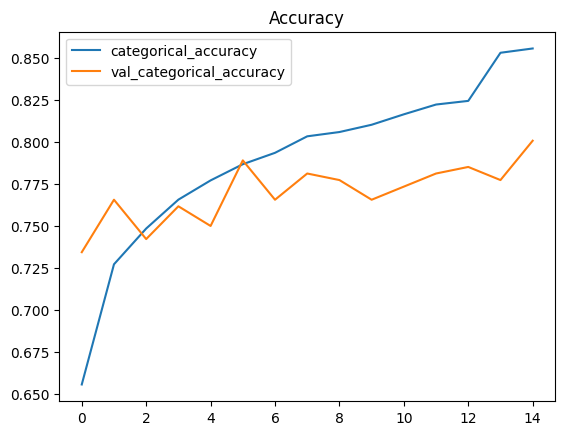

In [46]:
pd.DataFrame(results.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

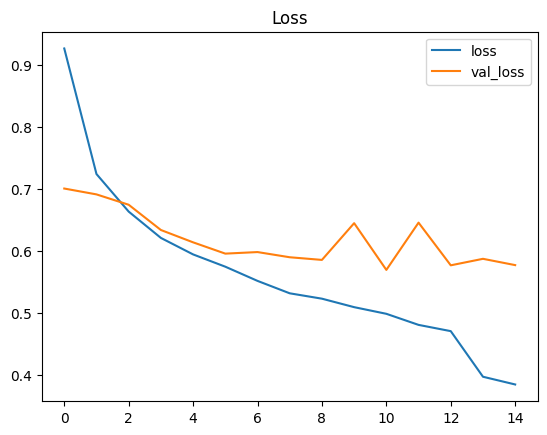

In [47]:
pd.DataFrame(results.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [48]:
MODEL_PATH = Path("/content/saved_model")
MODEL_PATH.mkdir(exist_ok=True)
mobilenetv2_wm28kL.save(f"{MODEL_PATH}/mobilenetv2_wm28kL_85_63.keras")

In [49]:
# dump the training history as well
np.save('model_history_85_63.npy', results.history)

# history=np.load('model_history.npy',allow_pickle='TRUE').item()

### Model Evaluation

In [50]:
results = mobilenetv2_wm28kL.evaluate(test)

 1/89 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - categorical_accuracy: 0.8125 - loss: 0.6477

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - categorical_accuracy: 0.7915 - loss: 0.5614


In [51]:
predictions = np.argmax(mobilenetv2_wm28kL.predict(test), axis=-1)

89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step


In [52]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

      Center       0.84      0.87      0.85       429
       Donut       0.84      0.66      0.74        56
    Edge-Loc       0.60      0.78      0.68       519
   Edge-Ring       0.98      0.95      0.97       968
         Loc       0.62      0.52      0.57       359
   Near-full       1.00      1.00      1.00        15
      Random       0.81      0.93      0.87        87
     Scratch       0.76      0.33      0.46       119
        none       0.65      0.61      0.63       295

    accuracy                           0.79      2847
   macro avg       0.79      0.74      0.75      2847
weighted avg       0.79      0.79      0.78      2847



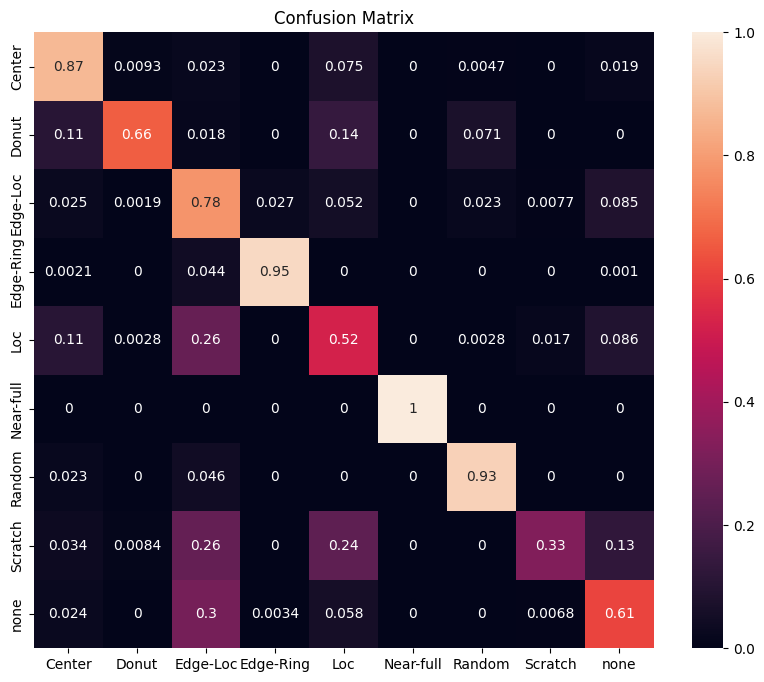

<Figure size 640x480 with 0 Axes>

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion_matrix.png')

In [1]:
mobilenetv2_wm28kL.save_weights("./mobilenetv2_wm28kL.weights.h5")

NameError: name 'mobilenetv2_wm28kL' is not defined